fristly download dependencies for pytorch and albumentation, as the dataset of images is quite small

In [ ]:
%%shell
pip install -U numpy
pip install -U git+https://github.com/albumentations-team/albumentations
pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

git clone https://github.com/pytorch/vision.git
cd vision


cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Requirement already up-to-date: numpy in /usr/local/lib/python3.6/dist-packages (1.19.4)
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-m3p2z0q4
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-m3p2z0q4
     |████████████████████████████████| 952kB 13.9MB/s 
  Created wheel for albumentations: filename=albumentations-0.5.2-cp36-none-any.whl size=79948 sha256=d067539898acdf2ed3052bba996149fb60e21155fa5885261a774aa3256c3c69
  Stored in directory: /tmp/pip-ephem-wheel-cache-qhc0b0hk/wheels/6f/77/82/86baf8aeda64a6de0f890cd0f2fb31acaf5545cc9c99ad21ba
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12
  Cloning https://github.com/cocodataset/cocoapi.git to

Download the dataset from google drive 

In [ ]:
#taken from this StackOverflow answer: https://stackoverflow.com/a/39225039
import requests

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

In [ ]:
import os

mini = '12cp74EKvQOHDBLZnBB-0VeXILSa5Bd18'
normal = '1xE2-Nq9lOWuj719Ba9w2WmNATikF65eI'

if(os.path.isfile('/object detection v1.zip') == False):
  download_file_from_google_drive(normal,'object detection v1.zip')
  !unzip -q "object detection v1.zip"

Defining the dataset from downloaded files. 

In [ ]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image
import xml.etree.ElementTree as ET
import transforms as T
import cv2
import albumentations as albu
import random


# XML parser
def read_content(xml_file: str):

    tree = ET.parse(xml_file)
    root = tree.getroot()

    list_with_all_boxes = []
    list_with_all_labels = []

    # Loop over bounding boxes in input image
    for boxes in root.iter('object'):

        filename = root.find('filename').text

        ymin, xmin, ymax, xmax = None, None, None, None

        for box in boxes.findall("bndbox"):
            ymin = int(box.find("ymin").text)
            xmin = int(box.find("xmin").text)
            ymax = int(box.find("ymax").text)
            xmax = int(box.find("xmax").text)

        for name in boxes.findall("name"):
            name = name.text

        list_with_single_boxes = [xmin, ymin, xmax, ymax]
        list_with_all_boxes.append(list_with_single_boxes)
        list_with_all_labels.append(name)
    return list_with_all_labels,list_with_all_boxes


#Give image shape. such we can scale correct. as input
def get_training_augmentation(h=100,w=100):
  height, width = 256, 256

  if h < 256:
    height = h
  if w < 256:
    width = w

  if h > 256:
    height = random.randint(int(h-(h/2)),h)
  if w > 256:
    width = random.randint(int(w-(w/2)),w)

  train_transform = [
    #albu.HorizontalFlip(p=0.5),
    albu.RandomBrightnessContrast(p=0.2),  
    albu.RandomCrop(height=height,width=width,p=1)
  ]
  return albu.Compose(train_transform)

#Give image shape. such we can scale correct. as input
def get_scaling_augmentation(h=100,w=100):
  h_scale = int(h * 3)
  w_scale = int(w * 3)
  train_transform = [
    ## Change this code for transformations
    #albu.transforms.Resize(height=h_scale,width=w_scale,always_apply=True)
  ]
  return albu.Compose(train_transform)

def get_aug(aug, min_area=0., min_visibility=0.):
  return albu.Compose(aug, bbox_params=albu.BboxParams(format='pascal_voc', min_area=min_area, 
                                              min_visibility=min_visibility, label_fields=['category_id']))

class TrainDatasetAugmented(torch.utils.data.Dataset):
  def __init__(self, root, transforms=None, eval=False):
    self.root = root
    self.transforms = transforms # note that transforms must be a reference to a function
    files = list(sorted(os.listdir(self.root + '/JPEGimages')))
    self.imgs = []
    self.eval = eval
    if self.eval == True:
      files = files[-5:]
    else:
      files = files[:(len(files)-5)]
      pass
    for f in files:
      if f.endswith(".jpg"):
        self.imgs.append(f[0:-4])
    
    self.classes = []
    for f in self.imgs:
      xml_path = self.root + '/Annotations/' + f + '.xml'
      names,boxes = read_content(xml_path)
      for name in names:
        if not name in self.classes:
          self.classes.append(name)

  def __getitem__(self, idx):
    try:
      # Load image
      img_path = self.root + '/JPEGimages/' + self.imgs[idx]+'.jpg'

      # Load bounding box coordinates + class names
      xml_path = self.root + '/Annotations/' + self.imgs[idx]+'.xml'
      names,boxes = read_content(xml_path)
      
      # get bounding box coordinates for each object
      num_objs = len(boxes)

      category_id = []
      for i in range(num_objs):
        for j in range(len(self.classes)):
          if names[i] == self.classes[j]:
            category_id.append(j)

      cimg = cv2.imread(img_path)
      cimg = cv2.cvtColor(cimg, cv2.COLOR_BGR2RGB)
      h,w,c = cimg.shape
      annotations = {'image': cimg, 'bboxes': boxes, 'category_id': category_id}
      
      if (self.eval == False):
        aug = get_aug(get_training_augmentation(h,w),min_visibility=0.5)
      else:
        aug = get_aug(get_scaling_augmentation(h,w),min_visibility=0.5)
    
      augmented = aug(**annotations)

      boxes = []
      for idx, bbox in enumerate(augmented['bboxes']):
        boxes.append(list(bbox))
      
      label_idx = augmented['category_id']

      img = augmented['image']
      #img = img.transpose(2, 0, 1).astype('float32')
      #img = torch.from_numpy(img)


      num_objs = len(boxes)
      print(num_objs)

      ##old code
      boxes = torch.as_tensor(boxes, dtype=torch.float32)
      

      labels = torch.zeros((num_objs,), dtype=torch.int64)
      for i in range(num_objs):
        labels[i] = label_idx[i]

      image_id = torch.tensor([idx])

    
      area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        
      # suppose all instances are not crowd
      iscrowd = torch.zeros((num_objs,), dtype=torch.int64)


      target = {}
      target["boxes"] = boxes
      target["labels"] = labels
      target["image_id"] = image_id
      target["area"] = area
      target["iscrowd"] = iscrowd

      # Apply data augmentation here by calling transforms function
      if self.transforms is not None:
          img, target = self.transforms(img, target)

      return img, target
    except:
      return self.__getitem__(idx)



  def __len__(self):
    return len(self.imgs)

tester:

In [ ]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image
import xml.etree.ElementTree as ET
import transforms as T
import cv2
import albumentations as albu
import random


# XML parser
def read_content(xml_file: str):

    tree = ET.parse(xml_file)
    root = tree.getroot()

    list_with_all_boxes = []
    list_with_all_labels = []

    # Loop over bounding boxes in input image
    for boxes in root.iter('object'):

        filename = root.find('filename').text

        ymin, xmin, ymax, xmax = None, None, None, None

        for box in boxes.findall("bndbox"):
            ymin = int(box.find("ymin").text)
            xmin = int(box.find("xmin").text)
            ymax = int(box.find("ymax").text)
            xmax = int(box.find("xmax").text)

        for name in boxes.findall("name"):
            name = name.text

        list_with_single_boxes = [xmin, ymin, xmax, ymax]
        list_with_all_boxes.append(list_with_single_boxes)
        list_with_all_labels.append(name)
    return list_with_all_labels,list_with_all_boxes

class TrainDatasetAugmented(torch.utils.data.Dataset):
  def __init__(self, root, transforms=None, eval=False):
    self.root = root
    self.transforms = transforms # note that transforms must be a reference to a function
    files = list(sorted(os.listdir(self.root + '/JPEGimages')))
    self.imgs = []
    self.eval = eval
    if self.eval == True:
      files = files[-10:]
    else:
      files = files[:(len(files)-5)]
      pass
    for f in files:
      if f.endswith(".jpg"):
        self.imgs.append(f[0:-4])
    
    self.classes = ['_bg']
    for f in self.imgs:
      xml_path = self.root + '/Annotations/' + f + '.xml'
      names,boxes = read_content(xml_path)
      for name in names:
        if not name in self.classes:
          self.classes.append(name)

  def __getitem__(self, idx):
    # Load image
    img_path = self.root + '/JPEGimages/' + self.imgs[idx]+'.jpg'
    img = Image.open(img_path).convert("RGB")

    # Load bounding box coordinates + class names
    xml_path = self.root + '/Annotations/' + self.imgs[idx]+'.xml'
    names,boxes = read_content(xml_path)
    
    # get bounding box coordinates for each object
    num_objs = len(boxes)

    boxes = torch.as_tensor(boxes, dtype=torch.float32)
    labels = torch.zeros((num_objs,), dtype=torch.int64)
    for i in range(num_objs):
      for j in range(len(self.classes)):
        if names[i] == self.classes[j]:
          labels[i] = j

    image_id = torch.tensor([idx])
    area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
    iscrowd = torch.zeros((num_objs,), dtype=torch.int64)


    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    target["image_id"] = image_id
    target["area"] = area
    target["iscrowd"] = iscrowd

    # Apply data augmentation here by calling transforms function
    if self.transforms is not None:
        img, target = self.transforms(img, target)

    return img, target


  def __len__(self):
    return len(self.imgs)

10
00002
number of classes: 9


<Figure size 432x288 with 0 Axes>

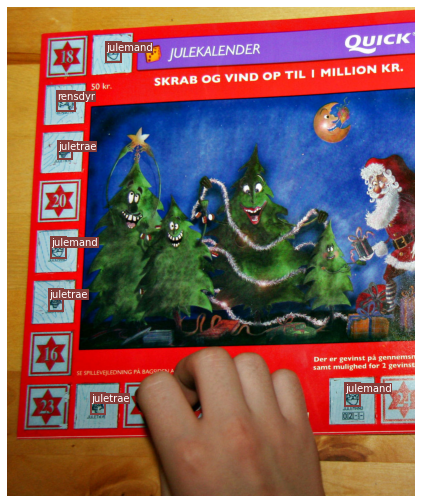

{'area': tensor([2880., 3477., 2365., 2852., 3337., 2752., 2688.]),
 'boxes': tensor([[ 299.,  107.,  347.,  167.],
         [ 150.,  257.,  207.,  318.],
         [ 154.,  409.,  197.,  464.],
         [ 132.,  701.,  178.,  763.],
         [1026., 1144., 1073., 1215.],
         [ 127.,  860.,  170.,  924.],
         [ 254., 1176.,  296., 1240.]]),
 'image_id': tensor([0]),
 'iscrowd': tensor([0, 0, 0, 0, 0, 0, 0]),
 'labels': tensor([1, 2, 3, 1, 1, 3, 3])}

In [ ]:
import transforms as T
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

# Set up dataset
dataset = TrainDatasetAugmented('kal-train',transforms=T.ToTensor())
datasetValidation = TrainDatasetAugmented('kal-train',transforms=T.ToTensor(),eval=True)


print(len(datasetValidation))
print(dataset.imgs[1])
# Get list af class names in dataset
classes = dataset.classes

print('number of classes:', len(classes))

# Set up some plotting conofigurations
cmap = plt.get_cmap('tab20b')
colors = [cmap(i) for i in np.linspace(0, 1, 20)]

def display_img(img,prediction):
  # Undo preprocessing
  img2 = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
  plt.figure()
  fig, ax = plt.subplots(1, figsize=(12,9))
  ax.imshow(img2)
  boxes = prediction['boxes'].cpu().numpy()
  labels = prediction['labels'].cpu().numpy()
  for i in range(boxes.shape[0]):
    x1 = boxes[i,0]
    y1 = boxes[i,1]
    box_w = boxes[i,2] - x1
    box_h = boxes[i,3] - y1

    color = colors[12]
    bbox = patches.Rectangle((x1, y1), box_w, box_h,
              linewidth=2, edgecolor=color, facecolor='none')
    ax.add_patch(bbox)
    plt.text(x1, y1, s=classes[labels[i]], 
                  color='white', verticalalignment='top',
                  bbox={'color': color, 'pad': 0})
  plt.axis('off')
  plt.show()

# pick random image from the test set
imgToDisplay = 0

indices = torch.randperm(len(dataset)).tolist()
img, prediction = dataset[imgToDisplay]

# Display image
display_img(img,prediction)

# This prints the corresponding metadata
dataset[imgToDisplay][0].shape
dataset[imgToDisplay][1]

Model definition 

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
      
def get_object_detect_model(num_classes):
  # load an instance segmentation model pre-trained on COCO
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

  # get the number of input features for the classifier
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  

  # replace the pre-trained head with a new one
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
  return model

In [ ]:
import utils

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    datasetValidation, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

In [ ]:
device = torch.device('cuda')

num_classes = len(dataset.classes)

model = get_object_detect_model(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.015,
                            momentum=0.9, weight_decay=0.0001)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=1,
                                               gamma=0.9)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


training

Epoch: [0]  [ 0/69]  eta: 0:01:08  lr: 0.000235  loss: 2.1588 (2.1588)  loss_classifier: 1.9701 (1.9701)  loss_box_reg: 0.1497 (0.1497)  loss_objectness: 0.0224 (0.0224)  loss_rpn_box_reg: 0.0166 (0.0166)  time: 0.9907  data: 0.2592  max mem: 1262
Epoch: [0]  [10/69]  eta: 0:00:20  lr: 0.002439  loss: 1.9267 (1.9642)  loss_classifier: 1.1595 (1.1420)  loss_box_reg: 0.2605 (0.3097)  loss_objectness: 0.2530 (0.4673)  loss_rpn_box_reg: 0.0242 (0.0452)  time: 0.3528  data: 0.0283  max mem: 1625
Epoch: [0]  [20/69]  eta: 0:00:15  lr: 0.004643  loss: 1.1427 (1.5658)  loss_classifier: 0.5338 (0.8485)  loss_box_reg: 0.3456 (0.3581)  loss_objectness: 0.1461 (0.3039)  loss_rpn_box_reg: 0.0242 (0.0553)  time: 0.2892  data: 0.0063  max mem: 1625
Epoch: [0]  [30/69]  eta: 0:00:12  lr: 0.006846  loss: 1.1427 (1.4798)  loss_classifier: 0.4202 (0.7835)  loss_box_reg: 0.3874 (0.4238)  loss_objectness: 0.0566 (0.2248)  loss_rpn_box_reg: 0.0208 (0.0478)  time: 0.2894  data: 0.0070  max mem: 1625
Epoch: [

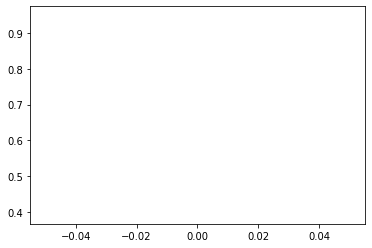

Epoch: [1]  [ 0/69]  eta: 0:01:14  lr: 0.013500  loss: 1.5562 (1.5562)  loss_classifier: 0.7773 (0.7773)  loss_box_reg: 0.4271 (0.4271)  loss_objectness: 0.0470 (0.0470)  loss_rpn_box_reg: 0.3048 (0.3048)  time: 1.0858  data: 0.7085  max mem: 1625
Epoch: [1]  [10/69]  eta: 0:00:20  lr: 0.013500  loss: 0.8351 (1.0068)  loss_classifier: 0.4897 (0.5208)  loss_box_reg: 0.4175 (0.4022)  loss_objectness: 0.0138 (0.0185)  loss_rpn_box_reg: 0.0378 (0.0653)  time: 0.3544  data: 0.0700  max mem: 1625
Epoch: [1]  [20/69]  eta: 0:00:15  lr: 0.013500  loss: 1.0980 (1.0868)  loss_classifier: 0.4954 (0.5480)  loss_box_reg: 0.4502 (0.4377)  loss_objectness: 0.0141 (0.0271)  loss_rpn_box_reg: 0.0395 (0.0740)  time: 0.2797  data: 0.0062  max mem: 1625
Epoch: [1]  [30/69]  eta: 0:00:12  lr: 0.013500  loss: 1.0791 (1.0319)  loss_classifier: 0.6049 (0.5331)  loss_box_reg: 0.4366 (0.4104)  loss_objectness: 0.0170 (0.0277)  loss_rpn_box_reg: 0.0329 (0.0606)  time: 0.2897  data: 0.0062  max mem: 1625
Epoch: [

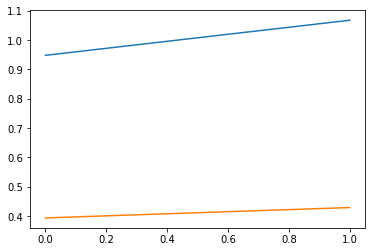

Epoch: [2]  [ 0/69]  eta: 0:01:13  lr: 0.012150  loss: 0.3793 (0.3793)  loss_classifier: 0.2642 (0.2642)  loss_box_reg: 0.1084 (0.1084)  loss_objectness: 0.0016 (0.0016)  loss_rpn_box_reg: 0.0050 (0.0050)  time: 1.0720  data: 0.7216  max mem: 1625
Epoch: [2]  [10/69]  eta: 0:00:21  lr: 0.012150  loss: 0.4801 (0.7737)  loss_classifier: 0.2642 (0.3490)  loss_box_reg: 0.2015 (0.2983)  loss_objectness: 0.0109 (0.0288)  loss_rpn_box_reg: 0.0316 (0.0976)  time: 0.3696  data: 0.0717  max mem: 1625
Epoch: [2]  [20/69]  eta: 0:00:16  lr: 0.012150  loss: 0.6726 (0.8220)  loss_classifier: 0.2588 (0.3581)  loss_box_reg: 0.2089 (0.2612)  loss_objectness: 0.0876 (0.1306)  loss_rpn_box_reg: 0.0316 (0.0721)  time: 0.2959  data: 0.0064  max mem: 1625
Epoch: [2]  [30/69]  eta: 0:00:12  lr: 0.012150  loss: 0.7826 (0.8767)  loss_classifier: 0.3588 (0.4099)  loss_box_reg: 0.2480 (0.2936)  loss_objectness: 0.0811 (0.1061)  loss_rpn_box_reg: 0.0333 (0.0671)  time: 0.2906  data: 0.0062  max mem: 1625
Epoch: [

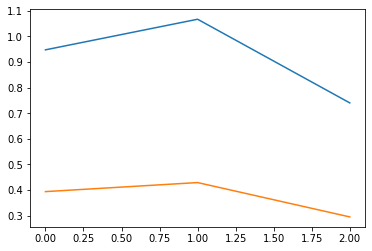

Epoch: [3]  [ 0/69]  eta: 0:01:04  lr: 0.010935  loss: 0.1994 (0.1994)  loss_classifier: 0.1320 (0.1320)  loss_box_reg: 0.0530 (0.0530)  loss_objectness: 0.0120 (0.0120)  loss_rpn_box_reg: 0.0023 (0.0023)  time: 0.9359  data: 0.6258  max mem: 1625
Epoch: [3]  [10/69]  eta: 0:00:20  lr: 0.010935  loss: 0.6910 (0.7245)  loss_classifier: 0.2474 (0.3325)  loss_box_reg: 0.3925 (0.3358)  loss_objectness: 0.0258 (0.0327)  loss_rpn_box_reg: 0.0206 (0.0235)  time: 0.3526  data: 0.0604  max mem: 1625
Epoch: [3]  [20/69]  eta: 0:00:15  lr: 0.010935  loss: 0.4468 (0.5562)  loss_classifier: 0.2129 (0.2568)  loss_box_reg: 0.1755 (0.2538)  loss_objectness: 0.0121 (0.0252)  loss_rpn_box_reg: 0.0175 (0.0204)  time: 0.2959  data: 0.0053  max mem: 1625
Epoch: [3]  [30/69]  eta: 0:00:12  lr: 0.010935  loss: 0.3620 (0.5721)  loss_classifier: 0.1412 (0.2563)  loss_box_reg: 0.1755 (0.2707)  loss_objectness: 0.0043 (0.0205)  loss_rpn_box_reg: 0.0192 (0.0246)  time: 0.3003  data: 0.0065  max mem: 1625
Epoch: [

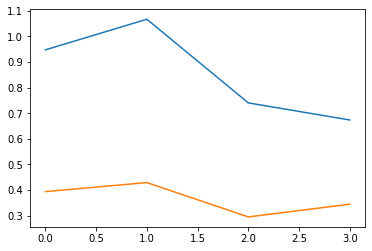

Epoch: [4]  [ 0/69]  eta: 0:01:09  lr: 0.009842  loss: 0.6825 (0.6825)  loss_classifier: 0.1898 (0.1898)  loss_box_reg: 0.4317 (0.4317)  loss_objectness: 0.0063 (0.0063)  loss_rpn_box_reg: 0.0547 (0.0547)  time: 1.0055  data: 0.6541  max mem: 1625
Epoch: [4]  [10/69]  eta: 0:00:21  lr: 0.009842  loss: 0.5794 (0.5477)  loss_classifier: 0.1885 (0.2016)  loss_box_reg: 0.3296 (0.3160)  loss_objectness: 0.0071 (0.0091)  loss_rpn_box_reg: 0.0154 (0.0209)  time: 0.3625  data: 0.0638  max mem: 1625
Epoch: [4]  [20/69]  eta: 0:00:15  lr: 0.009842  loss: 0.5344 (0.5353)  loss_classifier: 0.1885 (0.2217)  loss_box_reg: 0.2865 (0.2755)  loss_objectness: 0.0071 (0.0097)  loss_rpn_box_reg: 0.0125 (0.0284)  time: 0.2922  data: 0.0054  max mem: 1625
Epoch: [4]  [30/69]  eta: 0:00:12  lr: 0.009842  loss: 0.4996 (0.5395)  loss_classifier: 0.1504 (0.2243)  loss_box_reg: 0.2737 (0.2802)  loss_objectness: 0.0057 (0.0096)  loss_rpn_box_reg: 0.0146 (0.0255)  time: 0.2875  data: 0.0059  max mem: 1625
Epoch: [

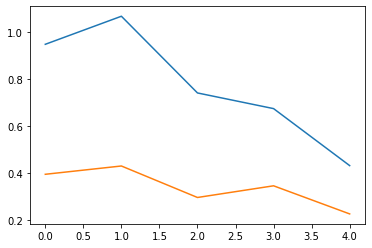

Epoch: [5]  [ 0/69]  eta: 0:00:31  lr: 0.008857  loss: 0.1726 (0.1726)  loss_classifier: 0.1269 (0.1269)  loss_box_reg: 0.0434 (0.0434)  loss_objectness: 0.0012 (0.0012)  loss_rpn_box_reg: 0.0012 (0.0012)  time: 0.4556  data: 0.1615  max mem: 1625
Epoch: [5]  [10/69]  eta: 0:00:20  lr: 0.008857  loss: 0.3699 (0.3686)  loss_classifier: 0.1334 (0.1578)  loss_box_reg: 0.2204 (0.1960)  loss_objectness: 0.0015 (0.0033)  loss_rpn_box_reg: 0.0079 (0.0115)  time: 0.3505  data: 0.0566  max mem: 1625
Epoch: [5]  [20/69]  eta: 0:00:16  lr: 0.008857  loss: 0.3585 (0.3636)  loss_classifier: 0.1182 (0.1470)  loss_box_reg: 0.2204 (0.2015)  loss_objectness: 0.0019 (0.0040)  loss_rpn_box_reg: 0.0079 (0.0110)  time: 0.3241  data: 0.0261  max mem: 1625
Epoch: [5]  [30/69]  eta: 0:00:12  lr: 0.008857  loss: 0.4142 (0.4180)  loss_classifier: 0.1067 (0.1551)  loss_box_reg: 0.2747 (0.2456)  loss_objectness: 0.0024 (0.0041)  loss_rpn_box_reg: 0.0077 (0.0131)  time: 0.2989  data: 0.0063  max mem: 1625
Epoch: [

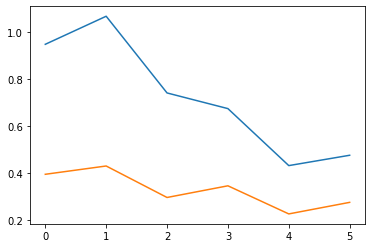

Epoch: [6]  [ 0/69]  eta: 0:01:14  lr: 0.007972  loss: 0.1883 (0.1883)  loss_classifier: 0.0564 (0.0564)  loss_box_reg: 0.1241 (0.1241)  loss_objectness: 0.0022 (0.0022)  loss_rpn_box_reg: 0.0055 (0.0055)  time: 1.0790  data: 0.7128  max mem: 1625
Epoch: [6]  [10/69]  eta: 0:00:22  lr: 0.007972  loss: 0.4469 (0.3868)  loss_classifier: 0.0897 (0.1204)  loss_box_reg: 0.2445 (0.2477)  loss_objectness: 0.0022 (0.0032)  loss_rpn_box_reg: 0.0055 (0.0155)  time: 0.3794  data: 0.0709  max mem: 1625
Epoch: [6]  [20/69]  eta: 0:00:16  lr: 0.007972  loss: 0.3950 (0.3553)  loss_classifier: 0.0897 (0.1067)  loss_box_reg: 0.2445 (0.2315)  loss_objectness: 0.0020 (0.0037)  loss_rpn_box_reg: 0.0045 (0.0134)  time: 0.3005  data: 0.0067  max mem: 1625
Epoch: [6]  [30/69]  eta: 0:00:12  lr: 0.007972  loss: 0.3746 (0.3685)  loss_classifier: 0.1004 (0.1144)  loss_box_reg: 0.2447 (0.2387)  loss_objectness: 0.0015 (0.0034)  loss_rpn_box_reg: 0.0055 (0.0120)  time: 0.2905  data: 0.0062  max mem: 1625
Epoch: [

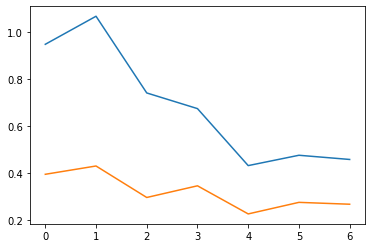

Epoch: [7]  [ 0/69]  eta: 0:01:06  lr: 0.007174  loss: 0.4119 (0.4119)  loss_classifier: 0.1518 (0.1518)  loss_box_reg: 0.2379 (0.2379)  loss_objectness: 0.0085 (0.0085)  loss_rpn_box_reg: 0.0137 (0.0137)  time: 0.9621  data: 0.5762  max mem: 1625
Epoch: [7]  [10/69]  eta: 0:00:21  lr: 0.007174  loss: 0.4711 (0.4141)  loss_classifier: 0.1509 (0.1294)  loss_box_reg: 0.2875 (0.2631)  loss_objectness: 0.0020 (0.0034)  loss_rpn_box_reg: 0.0123 (0.0181)  time: 0.3597  data: 0.0576  max mem: 1625
Epoch: [7]  [20/69]  eta: 0:00:16  lr: 0.007174  loss: 0.3224 (0.3535)  loss_classifier: 0.0805 (0.1101)  loss_box_reg: 0.2411 (0.2271)  loss_objectness: 0.0016 (0.0031)  loss_rpn_box_reg: 0.0081 (0.0132)  time: 0.2958  data: 0.0060  max mem: 1625
Epoch: [7]  [30/69]  eta: 0:00:12  lr: 0.007174  loss: 0.2541 (0.3434)  loss_classifier: 0.0596 (0.0961)  loss_box_reg: 0.1930 (0.2301)  loss_objectness: 0.0013 (0.0030)  loss_rpn_box_reg: 0.0040 (0.0141)  time: 0.2952  data: 0.0065  max mem: 1625
Epoch: [

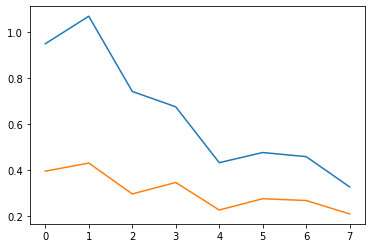

Epoch: [8]  [ 0/69]  eta: 0:01:17  lr: 0.006457  loss: 0.3389 (0.3389)  loss_classifier: 0.1266 (0.1266)  loss_box_reg: 0.1975 (0.1975)  loss_objectness: 0.0010 (0.0010)  loss_rpn_box_reg: 0.0138 (0.0138)  time: 1.1235  data: 0.7792  max mem: 1625
Epoch: [8]  [10/69]  eta: 0:00:21  lr: 0.006457  loss: 0.3276 (0.3217)  loss_classifier: 0.0813 (0.0937)  loss_box_reg: 0.2194 (0.2150)  loss_objectness: 0.0013 (0.0017)  loss_rpn_box_reg: 0.0090 (0.0113)  time: 0.3711  data: 0.0750  max mem: 1625
Epoch: [8]  [20/69]  eta: 0:00:16  lr: 0.006457  loss: 0.2874 (0.2924)  loss_classifier: 0.0777 (0.0885)  loss_box_reg: 0.2114 (0.1920)  loss_objectness: 0.0012 (0.0017)  loss_rpn_box_reg: 0.0062 (0.0101)  time: 0.2927  data: 0.0058  max mem: 1625
Epoch: [8]  [30/69]  eta: 0:00:12  lr: 0.006457  loss: 0.2782 (0.2844)  loss_classifier: 0.0720 (0.0868)  loss_box_reg: 0.1713 (0.1853)  loss_objectness: 0.0009 (0.0020)  loss_rpn_box_reg: 0.0049 (0.0103)  time: 0.2943  data: 0.0068  max mem: 1625
Epoch: [

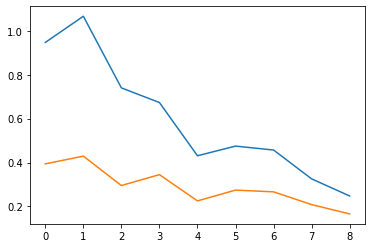

Epoch: [9]  [ 0/69]  eta: 0:01:27  lr: 0.005811  loss: 0.4127 (0.4127)  loss_classifier: 0.0743 (0.0743)  loss_box_reg: 0.3180 (0.3180)  loss_objectness: 0.0007 (0.0007)  loss_rpn_box_reg: 0.0197 (0.0197)  time: 1.2643  data: 0.8574  max mem: 1625
Epoch: [9]  [10/69]  eta: 0:00:22  lr: 0.005811  loss: 0.2945 (0.3186)  loss_classifier: 0.0743 (0.0848)  loss_box_reg: 0.2070 (0.2205)  loss_objectness: 0.0007 (0.0023)  loss_rpn_box_reg: 0.0103 (0.0111)  time: 0.3840  data: 0.0827  max mem: 1625
Epoch: [9]  [20/69]  eta: 0:00:16  lr: 0.005811  loss: 0.2815 (0.2783)  loss_classifier: 0.0550 (0.0755)  loss_box_reg: 0.1968 (0.1891)  loss_objectness: 0.0007 (0.0029)  loss_rpn_box_reg: 0.0055 (0.0108)  time: 0.2924  data: 0.0058  max mem: 1625
Epoch: [9]  [30/69]  eta: 0:00:12  lr: 0.005811  loss: 0.2159 (0.2769)  loss_classifier: 0.0480 (0.0799)  loss_box_reg: 0.1399 (0.1843)  loss_objectness: 0.0008 (0.0025)  loss_rpn_box_reg: 0.0055 (0.0101)  time: 0.2952  data: 0.0065  max mem: 1625
Epoch: [

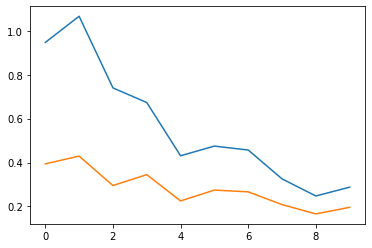

Epoch: [10]  [ 0/69]  eta: 0:01:17  lr: 0.005230  loss: 0.1115 (0.1115)  loss_classifier: 0.0136 (0.0136)  loss_box_reg: 0.0950 (0.0950)  loss_objectness: 0.0013 (0.0013)  loss_rpn_box_reg: 0.0016 (0.0016)  time: 1.1252  data: 0.6820  max mem: 1625
Epoch: [10]  [10/69]  eta: 0:00:22  lr: 0.005230  loss: 0.2403 (0.2491)  loss_classifier: 0.0555 (0.0724)  loss_box_reg: 0.1401 (0.1670)  loss_objectness: 0.0007 (0.0011)  loss_rpn_box_reg: 0.0092 (0.0086)  time: 0.3750  data: 0.0675  max mem: 1625
Epoch: [10]  [20/69]  eta: 0:00:16  lr: 0.005230  loss: 0.2646 (0.2704)  loss_classifier: 0.0697 (0.0794)  loss_box_reg: 0.1897 (0.1801)  loss_objectness: 0.0007 (0.0020)  loss_rpn_box_reg: 0.0070 (0.0088)  time: 0.3020  data: 0.0062  max mem: 1625
Epoch: [10]  [30/69]  eta: 0:00:12  lr: 0.005230  loss: 0.2716 (0.2555)  loss_classifier: 0.0695 (0.0739)  loss_box_reg: 0.1900 (0.1716)  loss_objectness: 0.0007 (0.0021)  loss_rpn_box_reg: 0.0054 (0.0078)  time: 0.3011  data: 0.0066  max mem: 1625
Epoc

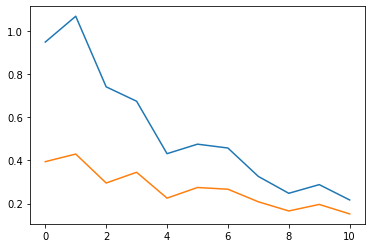

Epoch: [11]  [ 0/69]  eta: 0:01:02  lr: 0.004707  loss: 0.3315 (0.3315)  loss_classifier: 0.0734 (0.0734)  loss_box_reg: 0.2482 (0.2482)  loss_objectness: 0.0010 (0.0010)  loss_rpn_box_reg: 0.0090 (0.0090)  time: 0.9054  data: 0.5167  max mem: 1625
Epoch: [11]  [10/69]  eta: 0:00:20  lr: 0.004707  loss: 0.2138 (0.2239)  loss_classifier: 0.0576 (0.0638)  loss_box_reg: 0.1421 (0.1531)  loss_objectness: 0.0007 (0.0022)  loss_rpn_box_reg: 0.0037 (0.0047)  time: 0.3530  data: 0.0537  max mem: 1625
Epoch: [11]  [20/69]  eta: 0:00:15  lr: 0.004707  loss: 0.2102 (0.2168)  loss_classifier: 0.0546 (0.0621)  loss_box_reg: 0.1322 (0.1471)  loss_objectness: 0.0007 (0.0019)  loss_rpn_box_reg: 0.0029 (0.0057)  time: 0.2922  data: 0.0063  max mem: 1625
Epoch: [11]  [30/69]  eta: 0:00:12  lr: 0.004707  loss: 0.1349 (0.2097)  loss_classifier: 0.0394 (0.0614)  loss_box_reg: 0.1002 (0.1412)  loss_objectness: 0.0004 (0.0017)  loss_rpn_box_reg: 0.0036 (0.0055)  time: 0.2914  data: 0.0060  max mem: 1625
Epoc

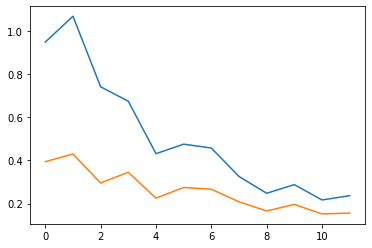

Epoch: [12]  [ 0/69]  eta: 0:01:15  lr: 0.004236  loss: 0.2491 (0.2491)  loss_classifier: 0.0602 (0.0602)  loss_box_reg: 0.1753 (0.1753)  loss_objectness: 0.0075 (0.0075)  loss_rpn_box_reg: 0.0061 (0.0061)  time: 1.0976  data: 0.7560  max mem: 1625
Epoch: [12]  [10/69]  eta: 0:00:22  lr: 0.004236  loss: 0.1936 (0.2211)  loss_classifier: 0.0490 (0.0550)  loss_box_reg: 0.1547 (0.1569)  loss_objectness: 0.0008 (0.0031)  loss_rpn_box_reg: 0.0039 (0.0061)  time: 0.3742  data: 0.0755  max mem: 1625
Epoch: [12]  [20/69]  eta: 0:00:16  lr: 0.004236  loss: 0.1928 (0.2125)  loss_classifier: 0.0452 (0.0524)  loss_box_reg: 0.1524 (0.1505)  loss_objectness: 0.0008 (0.0032)  loss_rpn_box_reg: 0.0039 (0.0064)  time: 0.2945  data: 0.0069  max mem: 1625
Epoch: [12]  [30/69]  eta: 0:00:12  lr: 0.004236  loss: 0.1801 (0.1925)  loss_classifier: 0.0478 (0.0500)  loss_box_reg: 0.1062 (0.1347)  loss_objectness: 0.0006 (0.0026)  loss_rpn_box_reg: 0.0030 (0.0053)  time: 0.2879  data: 0.0062  max mem: 1625
Epoc

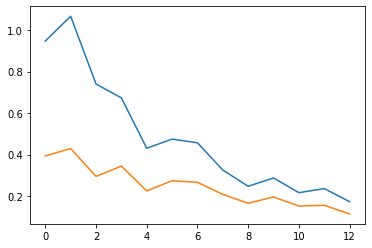

Epoch: [13]  [ 0/69]  eta: 0:01:11  lr: 0.003813  loss: 0.1196 (0.1196)  loss_classifier: 0.0367 (0.0367)  loss_box_reg: 0.0816 (0.0816)  loss_objectness: 0.0003 (0.0003)  loss_rpn_box_reg: 0.0010 (0.0010)  time: 1.0317  data: 0.6381  max mem: 1625
Epoch: [13]  [10/69]  eta: 0:00:22  lr: 0.003813  loss: 0.1535 (0.1559)  loss_classifier: 0.0389 (0.0442)  loss_box_reg: 0.1024 (0.1070)  loss_objectness: 0.0005 (0.0012)  loss_rpn_box_reg: 0.0021 (0.0035)  time: 0.3764  data: 0.0660  max mem: 1625
Epoch: [13]  [20/69]  eta: 0:00:16  lr: 0.003813  loss: 0.1300 (0.1513)  loss_classifier: 0.0399 (0.0437)  loss_box_reg: 0.0875 (0.1032)  loss_objectness: 0.0005 (0.0009)  loss_rpn_box_reg: 0.0021 (0.0035)  time: 0.3035  data: 0.0081  max mem: 1625
Epoch: [13]  [30/69]  eta: 0:00:12  lr: 0.003813  loss: 0.1515 (0.1625)  loss_classifier: 0.0399 (0.0426)  loss_box_reg: 0.1112 (0.1148)  loss_objectness: 0.0004 (0.0010)  loss_rpn_box_reg: 0.0021 (0.0042)  time: 0.2992  data: 0.0067  max mem: 1625
Epoc

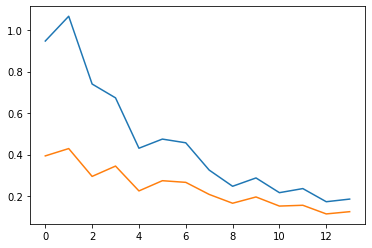

Epoch: [14]  [ 0/69]  eta: 0:00:57  lr: 0.003432  loss: 0.1812 (0.1812)  loss_classifier: 0.0623 (0.0623)  loss_box_reg: 0.1115 (0.1115)  loss_objectness: 0.0003 (0.0003)  loss_rpn_box_reg: 0.0071 (0.0071)  time: 0.8267  data: 0.4396  max mem: 1625
Epoch: [14]  [10/69]  eta: 0:00:20  lr: 0.003432  loss: 0.1701 (0.1539)  loss_classifier: 0.0460 (0.0414)  loss_box_reg: 0.1115 (0.1019)  loss_objectness: 0.0008 (0.0016)  loss_rpn_box_reg: 0.0046 (0.0089)  time: 0.3415  data: 0.0482  max mem: 1625
Epoch: [14]  [20/69]  eta: 0:00:15  lr: 0.003432  loss: 0.1662 (0.1570)  loss_classifier: 0.0358 (0.0433)  loss_box_reg: 0.1162 (0.1061)  loss_objectness: 0.0004 (0.0011)  loss_rpn_box_reg: 0.0029 (0.0065)  time: 0.2983  data: 0.0076  max mem: 1625
Epoch: [14]  [30/69]  eta: 0:00:12  lr: 0.003432  loss: 0.1662 (0.1631)  loss_classifier: 0.0426 (0.0445)  loss_box_reg: 0.1162 (0.1114)  loss_objectness: 0.0005 (0.0012)  loss_rpn_box_reg: 0.0031 (0.0060)  time: 0.3045  data: 0.0060  max mem: 1625
Epoc

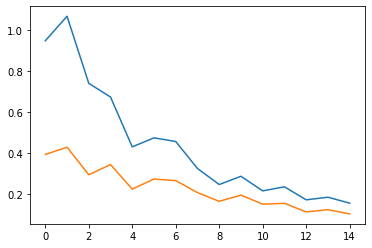

Epoch: [15]  [ 0/69]  eta: 0:01:16  lr: 0.003088  loss: 0.0435 (0.0435)  loss_classifier: 0.0089 (0.0089)  loss_box_reg: 0.0336 (0.0336)  loss_objectness: 0.0002 (0.0002)  loss_rpn_box_reg: 0.0008 (0.0008)  time: 1.1155  data: 0.7601  max mem: 1625
Epoch: [15]  [10/69]  eta: 0:00:22  lr: 0.003088  loss: 0.1148 (0.1211)  loss_classifier: 0.0290 (0.0363)  loss_box_reg: 0.0840 (0.0809)  loss_objectness: 0.0004 (0.0006)  loss_rpn_box_reg: 0.0021 (0.0033)  time: 0.3817  data: 0.0750  max mem: 1625
Epoch: [15]  [20/69]  eta: 0:00:16  lr: 0.003088  loss: 0.1148 (0.1189)  loss_classifier: 0.0294 (0.0347)  loss_box_reg: 0.0840 (0.0809)  loss_objectness: 0.0005 (0.0006)  loss_rpn_box_reg: 0.0019 (0.0027)  time: 0.3049  data: 0.0066  max mem: 1625
Epoch: [15]  [30/69]  eta: 0:00:12  lr: 0.003088  loss: 0.1349 (0.1353)  loss_classifier: 0.0311 (0.0413)  loss_box_reg: 0.1019 (0.0895)  loss_objectness: 0.0005 (0.0008)  loss_rpn_box_reg: 0.0014 (0.0037)  time: 0.2971  data: 0.0072  max mem: 1625
Epoc

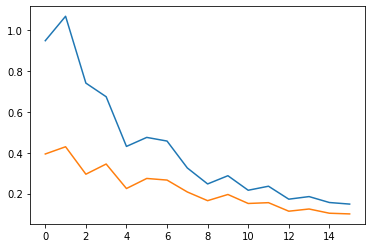

Epoch: [16]  [ 0/69]  eta: 0:00:56  lr: 0.002780  loss: 0.1422 (0.1422)  loss_classifier: 0.0292 (0.0292)  loss_box_reg: 0.1084 (0.1084)  loss_objectness: 0.0008 (0.0008)  loss_rpn_box_reg: 0.0037 (0.0037)  time: 0.8122  data: 0.4656  max mem: 1625
Epoch: [16]  [10/69]  eta: 0:00:20  lr: 0.002780  loss: 0.2117 (0.1931)  loss_classifier: 0.0571 (0.0580)  loss_box_reg: 0.1452 (0.1259)  loss_objectness: 0.0009 (0.0030)  loss_rpn_box_reg: 0.0048 (0.0061)  time: 0.3479  data: 0.0480  max mem: 1625
Epoch: [16]  [20/69]  eta: 0:00:15  lr: 0.002780  loss: 0.1784 (0.1778)  loss_classifier: 0.0486 (0.0575)  loss_box_reg: 0.1089 (0.1128)  loss_objectness: 0.0006 (0.0022)  loss_rpn_box_reg: 0.0029 (0.0052)  time: 0.2917  data: 0.0062  max mem: 1625
Epoch: [16]  [30/69]  eta: 0:00:11  lr: 0.002780  loss: 0.1200 (0.1550)  loss_classifier: 0.0363 (0.0485)  loss_box_reg: 0.0900 (0.1006)  loss_objectness: 0.0004 (0.0016)  loss_rpn_box_reg: 0.0023 (0.0042)  time: 0.2841  data: 0.0063  max mem: 1625
Epoc

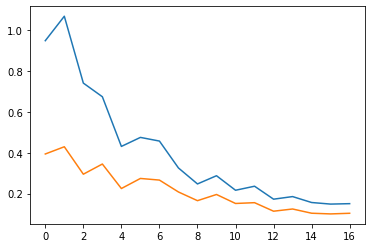

Epoch: [17]  [ 0/69]  eta: 0:01:04  lr: 0.002502  loss: 0.1503 (0.1503)  loss_classifier: 0.0488 (0.0488)  loss_box_reg: 0.0972 (0.0972)  loss_objectness: 0.0002 (0.0002)  loss_rpn_box_reg: 0.0041 (0.0041)  time: 0.9302  data: 0.6166  max mem: 1625
Epoch: [17]  [10/69]  eta: 0:00:21  lr: 0.002502  loss: 0.1227 (0.1379)  loss_classifier: 0.0333 (0.0397)  loss_box_reg: 0.0871 (0.0936)  loss_objectness: 0.0002 (0.0012)  loss_rpn_box_reg: 0.0022 (0.0035)  time: 0.3611  data: 0.0603  max mem: 1625
Epoch: [17]  [20/69]  eta: 0:00:16  lr: 0.002502  loss: 0.1227 (0.1415)  loss_classifier: 0.0312 (0.0386)  loss_box_reg: 0.0871 (0.0979)  loss_objectness: 0.0003 (0.0011)  loss_rpn_box_reg: 0.0022 (0.0039)  time: 0.3026  data: 0.0056  max mem: 1625
Epoch: [17]  [30/69]  eta: 0:00:12  lr: 0.002502  loss: 0.1390 (0.1361)  loss_classifier: 0.0343 (0.0367)  loss_box_reg: 0.0961 (0.0946)  loss_objectness: 0.0003 (0.0011)  loss_rpn_box_reg: 0.0020 (0.0038)  time: 0.2956  data: 0.0063  max mem: 1625
Epoc

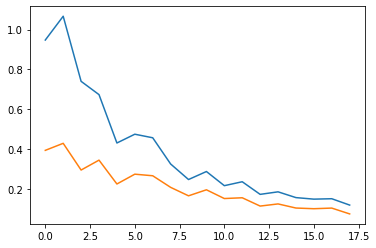

Epoch: [18]  [ 0/69]  eta: 0:01:18  lr: 0.002251  loss: 0.0310 (0.0310)  loss_classifier: 0.0124 (0.0124)  loss_box_reg: 0.0175 (0.0175)  loss_objectness: 0.0009 (0.0009)  loss_rpn_box_reg: 0.0003 (0.0003)  time: 1.1407  data: 0.7809  max mem: 1625
Epoch: [18]  [10/69]  eta: 0:00:22  lr: 0.002251  loss: 0.1215 (0.1111)  loss_classifier: 0.0330 (0.0362)  loss_box_reg: 0.0732 (0.0705)  loss_objectness: 0.0005 (0.0014)  loss_rpn_box_reg: 0.0020 (0.0031)  time: 0.3771  data: 0.0763  max mem: 1625
Epoch: [18]  [20/69]  eta: 0:00:16  lr: 0.002251  loss: 0.1053 (0.1134)  loss_classifier: 0.0380 (0.0370)  loss_box_reg: 0.0645 (0.0720)  loss_objectness: 0.0004 (0.0010)  loss_rpn_box_reg: 0.0020 (0.0034)  time: 0.2950  data: 0.0063  max mem: 1625
Epoch: [18]  [30/69]  eta: 0:00:12  lr: 0.002251  loss: 0.1147 (0.1233)  loss_classifier: 0.0357 (0.0391)  loss_box_reg: 0.0760 (0.0797)  loss_objectness: 0.0004 (0.0009)  loss_rpn_box_reg: 0.0021 (0.0037)  time: 0.2901  data: 0.0060  max mem: 1625
Epoc

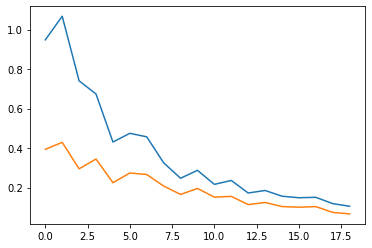

Epoch: [19]  [ 0/69]  eta: 0:00:56  lr: 0.002026  loss: 0.1217 (0.1217)  loss_classifier: 0.0439 (0.0439)  loss_box_reg: 0.0745 (0.0745)  loss_objectness: 0.0001 (0.0001)  loss_rpn_box_reg: 0.0031 (0.0031)  time: 0.8155  data: 0.3967  max mem: 1625
Epoch: [19]  [10/69]  eta: 0:00:21  lr: 0.002026  loss: 0.0843 (0.0836)  loss_classifier: 0.0293 (0.0262)  loss_box_reg: 0.0538 (0.0537)  loss_objectness: 0.0005 (0.0018)  loss_rpn_box_reg: 0.0011 (0.0020)  time: 0.3586  data: 0.0470  max mem: 1625
Epoch: [19]  [20/69]  eta: 0:00:16  lr: 0.002026  loss: 0.0685 (0.1004)  loss_classifier: 0.0280 (0.0337)  loss_box_reg: 0.0381 (0.0628)  loss_objectness: 0.0005 (0.0013)  loss_rpn_box_reg: 0.0011 (0.0026)  time: 0.3081  data: 0.0092  max mem: 1625
Epoch: [19]  [30/69]  eta: 0:00:12  lr: 0.002026  loss: 0.1195 (0.1028)  loss_classifier: 0.0319 (0.0337)  loss_box_reg: 0.0712 (0.0654)  loss_objectness: 0.0002 (0.0010)  loss_rpn_box_reg: 0.0018 (0.0027)  time: 0.3013  data: 0.0064  max mem: 1625
Epoc

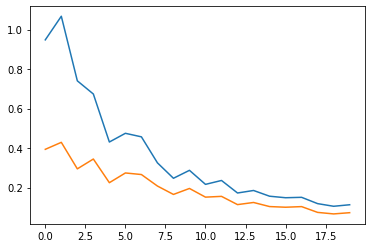

Epoch: [20]  [ 0/69]  eta: 0:00:59  lr: 0.001824  loss: 0.1835 (0.1835)  loss_classifier: 0.0502 (0.0502)  loss_box_reg: 0.1229 (0.1229)  loss_objectness: 0.0012 (0.0012)  loss_rpn_box_reg: 0.0092 (0.0092)  time: 0.8592  data: 0.4864  max mem: 1625
Epoch: [20]  [10/69]  eta: 0:00:21  lr: 0.001824  loss: 0.0963 (0.1007)  loss_classifier: 0.0259 (0.0331)  loss_box_reg: 0.0561 (0.0647)  loss_objectness: 0.0002 (0.0003)  loss_rpn_box_reg: 0.0017 (0.0026)  time: 0.3618  data: 0.0587  max mem: 1625
Epoch: [20]  [20/69]  eta: 0:00:16  lr: 0.001824  loss: 0.0828 (0.0943)  loss_classifier: 0.0265 (0.0311)  loss_box_reg: 0.0549 (0.0602)  loss_objectness: 0.0002 (0.0006)  loss_rpn_box_reg: 0.0016 (0.0024)  time: 0.3082  data: 0.0109  max mem: 1625
Epoch: [20]  [30/69]  eta: 0:00:12  lr: 0.001824  loss: 0.1169 (0.1220)  loss_classifier: 0.0401 (0.0399)  loss_box_reg: 0.0766 (0.0770)  loss_objectness: 0.0003 (0.0016)  loss_rpn_box_reg: 0.0020 (0.0036)  time: 0.2981  data: 0.0060  max mem: 1625
Epoc

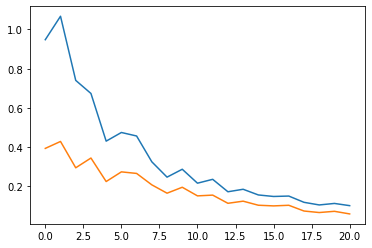

Epoch: [21]  [ 0/69]  eta: 0:00:34  lr: 0.001641  loss: 0.0757 (0.0757)  loss_classifier: 0.0285 (0.0285)  loss_box_reg: 0.0334 (0.0334)  loss_objectness: 0.0128 (0.0128)  loss_rpn_box_reg: 0.0010 (0.0010)  time: 0.5059  data: 0.1537  max mem: 1625
Epoch: [21]  [10/69]  eta: 0:00:17  lr: 0.001641  loss: 0.1370 (0.1299)  loss_classifier: 0.0438 (0.0400)  loss_box_reg: 0.0793 (0.0832)  loss_objectness: 0.0010 (0.0022)  loss_rpn_box_reg: 0.0026 (0.0046)  time: 0.3013  data: 0.0192  max mem: 1625
Epoch: [21]  [20/69]  eta: 0:00:14  lr: 0.001641  loss: 0.0987 (0.1175)  loss_classifier: 0.0297 (0.0372)  loss_box_reg: 0.0658 (0.0750)  loss_objectness: 0.0003 (0.0014)  loss_rpn_box_reg: 0.0022 (0.0039)  time: 0.2914  data: 0.0061  max mem: 1625
Epoch: [21]  [30/69]  eta: 0:00:11  lr: 0.001641  loss: 0.0831 (0.1118)  loss_classifier: 0.0285 (0.0374)  loss_box_reg: 0.0570 (0.0699)  loss_objectness: 0.0002 (0.0011)  loss_rpn_box_reg: 0.0015 (0.0034)  time: 0.3041  data: 0.0071  max mem: 1625
Epoc

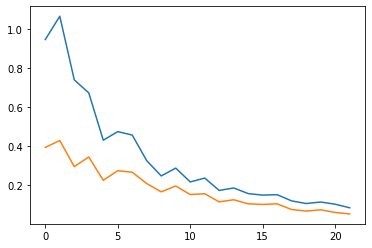

Epoch: [22]  [ 0/69]  eta: 0:01:15  lr: 0.001477  loss: 0.0394 (0.0394)  loss_classifier: 0.0091 (0.0091)  loss_box_reg: 0.0297 (0.0297)  loss_objectness: 0.0000 (0.0000)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 1.0970  data: 0.7023  max mem: 1625
Epoch: [22]  [10/69]  eta: 0:00:21  lr: 0.001477  loss: 0.0803 (0.0812)  loss_classifier: 0.0268 (0.0287)  loss_box_reg: 0.0557 (0.0485)  loss_objectness: 0.0002 (0.0021)  loss_rpn_box_reg: 0.0016 (0.0020)  time: 0.3676  data: 0.0687  max mem: 1625
Epoch: [22]  [20/69]  eta: 0:00:16  lr: 0.001477  loss: 0.0803 (0.0797)  loss_classifier: 0.0300 (0.0281)  loss_box_reg: 0.0435 (0.0485)  loss_objectness: 0.0002 (0.0012)  loss_rpn_box_reg: 0.0015 (0.0019)  time: 0.2932  data: 0.0054  max mem: 1625
Epoch: [22]  [30/69]  eta: 0:00:12  lr: 0.001477  loss: 0.0721 (0.0817)  loss_classifier: 0.0286 (0.0295)  loss_box_reg: 0.0391 (0.0495)  loss_objectness: 0.0002 (0.0009)  loss_rpn_box_reg: 0.0015 (0.0018)  time: 0.2927  data: 0.0059  max mem: 1625
Epoc

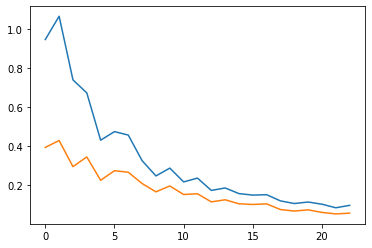

Epoch: [23]  [ 0/69]  eta: 0:01:23  lr: 0.001329  loss: 0.0544 (0.0544)  loss_classifier: 0.0202 (0.0202)  loss_box_reg: 0.0330 (0.0330)  loss_objectness: 0.0001 (0.0001)  loss_rpn_box_reg: 0.0011 (0.0011)  time: 1.2055  data: 0.8364  max mem: 1625
Epoch: [23]  [10/69]  eta: 0:00:22  lr: 0.001329  loss: 0.0544 (0.0915)  loss_classifier: 0.0208 (0.0266)  loss_box_reg: 0.0336 (0.0609)  loss_objectness: 0.0004 (0.0009)  loss_rpn_box_reg: 0.0008 (0.0031)  time: 0.3743  data: 0.0820  max mem: 1625
Epoch: [23]  [20/69]  eta: 0:00:16  lr: 0.001329  loss: 0.0775 (0.1045)  loss_classifier: 0.0311 (0.0319)  loss_box_reg: 0.0513 (0.0685)  loss_objectness: 0.0004 (0.0009)  loss_rpn_box_reg: 0.0019 (0.0033)  time: 0.2969  data: 0.0062  max mem: 1625
Epoch: [23]  [30/69]  eta: 0:00:12  lr: 0.001329  loss: 0.0876 (0.0953)  loss_classifier: 0.0356 (0.0314)  loss_box_reg: 0.0537 (0.0602)  loss_objectness: 0.0003 (0.0008)  loss_rpn_box_reg: 0.0017 (0.0029)  time: 0.2959  data: 0.0062  max mem: 1625
Epoc

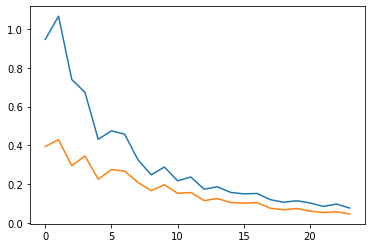

Epoch: [24]  [ 0/69]  eta: 0:01:08  lr: 0.001196  loss: 0.0397 (0.0397)  loss_classifier: 0.0231 (0.0231)  loss_box_reg: 0.0160 (0.0160)  loss_objectness: 0.0001 (0.0001)  loss_rpn_box_reg: 0.0005 (0.0005)  time: 0.9957  data: 0.6619  max mem: 1625
Epoch: [24]  [10/69]  eta: 0:00:21  lr: 0.001196  loss: 0.0660 (0.0772)  loss_classifier: 0.0241 (0.0285)  loss_box_reg: 0.0419 (0.0467)  loss_objectness: 0.0002 (0.0002)  loss_rpn_box_reg: 0.0011 (0.0018)  time: 0.3712  data: 0.0666  max mem: 1625
Epoch: [24]  [20/69]  eta: 0:00:16  lr: 0.001196  loss: 0.0660 (0.0810)  loss_classifier: 0.0247 (0.0318)  loss_box_reg: 0.0419 (0.0473)  loss_objectness: 0.0002 (0.0003)  loss_rpn_box_reg: 0.0011 (0.0017)  time: 0.3000  data: 0.0068  max mem: 1625
Epoch: [24]  [30/69]  eta: 0:00:12  lr: 0.001196  loss: 0.0598 (0.0733)  loss_classifier: 0.0238 (0.0285)  loss_box_reg: 0.0245 (0.0424)  loss_objectness: 0.0002 (0.0006)  loss_rpn_box_reg: 0.0009 (0.0018)  time: 0.2948  data: 0.0065  max mem: 1625
Epoc

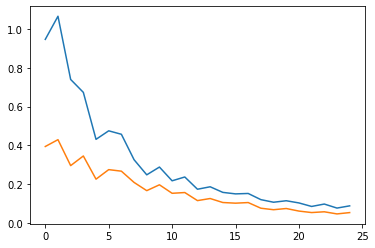

Epoch: [25]  [ 0/69]  eta: 0:01:11  lr: 0.001077  loss: 0.1315 (0.1315)  loss_classifier: 0.0410 (0.0410)  loss_box_reg: 0.0851 (0.0851)  loss_objectness: 0.0005 (0.0005)  loss_rpn_box_reg: 0.0049 (0.0049)  time: 1.0396  data: 0.7148  max mem: 1625
Epoch: [25]  [10/69]  eta: 0:00:21  lr: 0.001077  loss: 0.0803 (0.0999)  loss_classifier: 0.0392 (0.0316)  loss_box_reg: 0.0460 (0.0635)  loss_objectness: 0.0004 (0.0016)  loss_rpn_box_reg: 0.0022 (0.0031)  time: 0.3671  data: 0.0704  max mem: 1625
Epoch: [25]  [20/69]  eta: 0:00:16  lr: 0.001077  loss: 0.0776 (0.0885)  loss_classifier: 0.0275 (0.0301)  loss_box_reg: 0.0412 (0.0546)  loss_objectness: 0.0003 (0.0011)  loss_rpn_box_reg: 0.0015 (0.0027)  time: 0.2931  data: 0.0058  max mem: 1625
Epoch: [25]  [30/69]  eta: 0:00:12  lr: 0.001077  loss: 0.0532 (0.0802)  loss_classifier: 0.0249 (0.0298)  loss_box_reg: 0.0309 (0.0474)  loss_objectness: 0.0002 (0.0008)  loss_rpn_box_reg: 0.0008 (0.0022)  time: 0.2885  data: 0.0058  max mem: 1625
Epoc

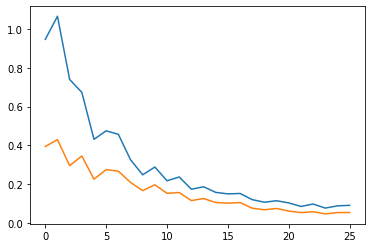

Epoch: [26]  [ 0/69]  eta: 0:01:11  lr: 0.000969  loss: 0.0512 (0.0512)  loss_classifier: 0.0294 (0.0294)  loss_box_reg: 0.0211 (0.0211)  loss_objectness: 0.0001 (0.0001)  loss_rpn_box_reg: 0.0007 (0.0007)  time: 1.0393  data: 0.6844  max mem: 1625
Epoch: [26]  [10/69]  eta: 0:00:21  lr: 0.000969  loss: 0.0557 (0.0841)  loss_classifier: 0.0294 (0.0328)  loss_box_reg: 0.0320 (0.0473)  loss_objectness: 0.0002 (0.0016)  loss_rpn_box_reg: 0.0016 (0.0025)  time: 0.3678  data: 0.0701  max mem: 1625
Epoch: [26]  [20/69]  eta: 0:00:16  lr: 0.000969  loss: 0.0721 (0.0844)  loss_classifier: 0.0252 (0.0319)  loss_box_reg: 0.0372 (0.0471)  loss_objectness: 0.0003 (0.0032)  loss_rpn_box_reg: 0.0015 (0.0022)  time: 0.2930  data: 0.0074  max mem: 1625
Epoch: [26]  [30/69]  eta: 0:00:12  lr: 0.000969  loss: 0.0721 (0.0821)  loss_classifier: 0.0252 (0.0302)  loss_box_reg: 0.0372 (0.0474)  loss_objectness: 0.0003 (0.0023)  loss_rpn_box_reg: 0.0010 (0.0022)  time: 0.2931  data: 0.0064  max mem: 1625
Epoc

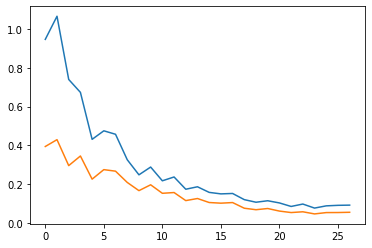

Epoch: [27]  [ 0/69]  eta: 0:01:18  lr: 0.000872  loss: 0.0351 (0.0351)  loss_classifier: 0.0152 (0.0152)  loss_box_reg: 0.0192 (0.0192)  loss_objectness: 0.0001 (0.0001)  loss_rpn_box_reg: 0.0006 (0.0006)  time: 1.1414  data: 0.7770  max mem: 1625
Epoch: [27]  [10/69]  eta: 0:00:22  lr: 0.000872  loss: 0.0801 (0.0946)  loss_classifier: 0.0323 (0.0355)  loss_box_reg: 0.0431 (0.0556)  loss_objectness: 0.0001 (0.0004)  loss_rpn_box_reg: 0.0018 (0.0030)  time: 0.3789  data: 0.0754  max mem: 1625
Epoch: [27]  [20/69]  eta: 0:00:16  lr: 0.000872  loss: 0.0801 (0.0947)  loss_classifier: 0.0323 (0.0374)  loss_box_reg: 0.0431 (0.0541)  loss_objectness: 0.0001 (0.0003)  loss_rpn_box_reg: 0.0018 (0.0028)  time: 0.2960  data: 0.0058  max mem: 1625
Epoch: [27]  [30/69]  eta: 0:00:12  lr: 0.000872  loss: 0.0701 (0.0896)  loss_classifier: 0.0310 (0.0346)  loss_box_reg: 0.0343 (0.0514)  loss_objectness: 0.0001 (0.0008)  loss_rpn_box_reg: 0.0016 (0.0028)  time: 0.2924  data: 0.0062  max mem: 1625
Epoc

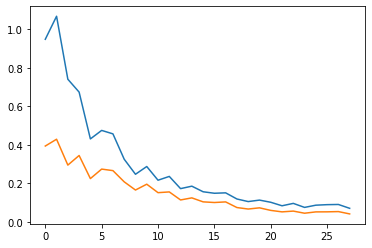

Epoch: [28]  [ 0/69]  eta: 0:00:55  lr: 0.000785  loss: 0.0220 (0.0220)  loss_classifier: 0.0097 (0.0097)  loss_box_reg: 0.0114 (0.0114)  loss_objectness: 0.0001 (0.0001)  loss_rpn_box_reg: 0.0008 (0.0008)  time: 0.8080  data: 0.4821  max mem: 1625
Epoch: [28]  [10/69]  eta: 0:00:20  lr: 0.000785  loss: 0.0624 (0.0658)  loss_classifier: 0.0265 (0.0288)  loss_box_reg: 0.0249 (0.0348)  loss_objectness: 0.0001 (0.0004)  loss_rpn_box_reg: 0.0016 (0.0019)  time: 0.3455  data: 0.0481  max mem: 1625
Epoch: [28]  [20/69]  eta: 0:00:15  lr: 0.000785  loss: 0.0624 (0.0729)  loss_classifier: 0.0262 (0.0309)  loss_box_reg: 0.0295 (0.0392)  loss_objectness: 0.0001 (0.0006)  loss_rpn_box_reg: 0.0011 (0.0022)  time: 0.2965  data: 0.0058  max mem: 1625
Epoch: [28]  [30/69]  eta: 0:00:12  lr: 0.000785  loss: 0.0588 (0.0669)  loss_classifier: 0.0251 (0.0283)  loss_box_reg: 0.0289 (0.0361)  loss_objectness: 0.0002 (0.0006)  loss_rpn_box_reg: 0.0010 (0.0019)  time: 0.2982  data: 0.0067  max mem: 1625
Epoc

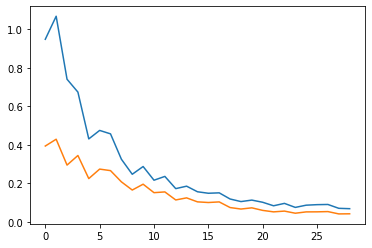

Epoch: [29]  [ 0/69]  eta: 0:01:02  lr: 0.000707  loss: 0.0643 (0.0643)  loss_classifier: 0.0289 (0.0289)  loss_box_reg: 0.0328 (0.0328)  loss_objectness: 0.0004 (0.0004)  loss_rpn_box_reg: 0.0022 (0.0022)  time: 0.9008  data: 0.4838  max mem: 1625
Epoch: [29]  [10/69]  eta: 0:00:20  lr: 0.000707  loss: 0.0643 (0.0601)  loss_classifier: 0.0263 (0.0289)  loss_box_reg: 0.0320 (0.0289)  loss_objectness: 0.0002 (0.0005)  loss_rpn_box_reg: 0.0016 (0.0018)  time: 0.3545  data: 0.0499  max mem: 1625
Epoch: [29]  [20/69]  eta: 0:00:16  lr: 0.000707  loss: 0.0655 (0.0731)  loss_classifier: 0.0259 (0.0309)  loss_box_reg: 0.0306 (0.0394)  loss_objectness: 0.0002 (0.0006)  loss_rpn_box_reg: 0.0013 (0.0023)  time: 0.2986  data: 0.0063  max mem: 1625
Epoch: [29]  [30/69]  eta: 0:00:12  lr: 0.000707  loss: 0.0655 (0.0771)  loss_classifier: 0.0259 (0.0300)  loss_box_reg: 0.0310 (0.0440)  loss_objectness: 0.0003 (0.0008)  loss_rpn_box_reg: 0.0015 (0.0023)  time: 0.2961  data: 0.0057  max mem: 1625
Epoc

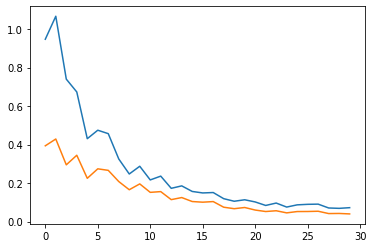

In [ ]:
from engine import train_one_epoch, evaluate

# let's train it for 10 epochs
num_epochs = 30

loss_log = []
box_reg = []
ap_log = []

for epoch in range(num_epochs):
    model.train()
    # train for one epoch, printing every 10 iterations
    m = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    loss_log.append(m.loss.avg)
    box_reg.append(m.loss_box_reg.avg)

    

    lr_scheduler.step()
    # e1valuate on the test dataset (skip this part)

    
    c_e = evaluate(model, data_loader_test, device=device)

    plt.plot(loss_log)
    plt.plot(box_reg)
    plt.show()




display predictions

In [ ]:
def checkPrice(count):
  win = False
  price = ''
  for e in count:
    if e == 'juletrae' and count[e] == 10:
      price = '10 Juletræer der udløser 1000000,- '
      win = True
    if e == 'julemand' and count[e] == 9:
      price = price + '9 Julemænd der udløser 50000,-'
      win = True
    if e == 'rensdyr' and count[e] == 8:
      price = price + '8 Rensdyr der udløser 5000,-'
      win = True
    if e == 'tromme' and count[e] == 7:
      price = price + '7 Rensdyr der udløser 1000,-'
      win = True
    if e == 'mistelten' and count[e] == 6:
      price = price + '6 Mistelteen der udløser 200,-'
      win = True
    if e == 'lys' and count[e] == 5:
      price = price + '5 Julelys der udløser 100,-'
      win = True
    if e == 'kugle' and count[e] == 4:
      price = price + '4 Julekugler der udløser 75,-'
      win = True
    if e == 'stjerne' and count[e] == 3:
      price = price + '3 Julestjerner der udløser 50,-'
      win = True
  return win, price


In [ ]:
def display_pred(img,prediction,ground_truth = None,threshold = 0.0):
  img2 = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
  plt.figure()
  fig, ax = plt.subplots(1, figsize=(12,9))
  ax.imshow(img2)
  boxes = prediction[0]['boxes'].cpu().numpy()
  labels = prediction[0]['labels'].cpu().numpy()
  scores = prediction[0]['scores'].cpu().numpy()
  
  if ground_truth is not None:
    gt_boxes = ground_truth['boxes'].cpu().numpy()
    gt_labels = ground_truth['labels'].cpu().numpy()
    for i in range (gt_boxes.shape[0]):
      x1 = gt_boxes[i,0]
      y1 = gt_boxes[i,1]
      box_w = gt_boxes[i,2] - x1
      box_h = gt_boxes[i,3] - y1

      color = colors[10]
      bbox = patches.Rectangle((x1, y1), box_w, box_h,
                linewidth=2, edgecolor=color, facecolor='none')
      ax.add_patch(bbox)
      #plt.text(x1, y1, s="Ground Truth", 
      #              color='white', verticalalignment='top',
      #              bbox={'color': color, 'pad': 0})

  counter = {
      'juletrae':0,
      'julemand':0,
      'rensdyr':0,
      'tromme':0,
      'mistelten':0,
      'lys':0,
      'kugle':0,
      'stjerne':0
  }

  for i in range(boxes.shape[0]):
    if scores[i] > threshold:
      #cCount[labels[i]] = cCount[labels[i]] + 1
      counter[dataset.classes[labels[i]]] = counter[dataset.classes[labels[i]]] + 1

      #print(i,wboxes[i,:],labels[i],scores[i])
      x1 = boxes[i,0]
      y1 = boxes[i,1]
      box_w = boxes[i,2] - x1
      box_h = boxes[i,3] - y1
      color = colors[0]
      bbox = patches.Rectangle((x1, y1), box_w, box_h,
                linewidth=2, edgecolor=color, facecolor='none')
      ax.add_patch(bbox)
      plt.text(x1, y1-10, s=dataset.classes[labels[i]], 
                    color='white', verticalalignment='top',
                    bbox={'color': color, 'pad': 0})
  print(counter)
  win, price = checkPrice(counter)
  if win:
    print('GEVINST! Der er :',price)
  else:
    print('Der var desværre ikke gevinst')
  plt.axis('off')
  plt.show()

# pick random image
#indices = torch.randperm(len(val_set)).tolist()
#datasets = torch.utils.data.Subset(val_set, indices)
#img, ground_true = datasets[0]


#print(len(dataset))
# put the model in evaluation mode
#model.eval()
#with torch.no_grad():
#    print(img.shape)
#    prediction = model([img.to(device)])
    # print(prediction)
#evaluate(model, data_loader_val, device=device)
#display_pred(img,prediction,ground_true,threshold=0.9)
#display_img(img,ground_true)

torch.Size([3, 2048, 1536])
{'juletrae': 0, 'julemand': 3, 'rensdyr': 1, 'tromme': 1, 'mistelten': 1, 'lys': 0, 'kugle': 0, 'stjerne': 0}
Der var desværre ikke gevinst


<Figure size 432x288 with 0 Axes>

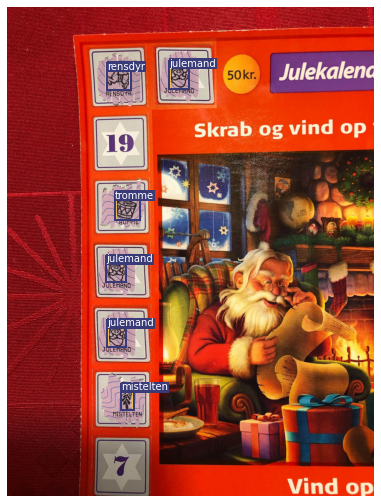

torch.Size([3, 1128, 976])
{'juletrae': 2, 'julemand': 8, 'rensdyr': 2, 'tromme': 6, 'mistelten': 1, 'lys': 1, 'kugle': 2, 'stjerne': 2}
Der var desværre ikke gevinst


<Figure size 432x288 with 0 Axes>

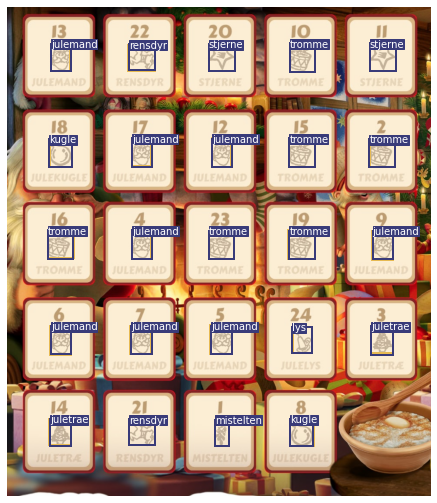

torch.Size([3, 2048, 1536])
{'juletrae': 3, 'julemand': 8, 'rensdyr': 0, 'tromme': 0, 'mistelten': 1, 'lys': 0, 'kugle': 0, 'stjerne': 1}
Der var desværre ikke gevinst


<Figure size 432x288 with 0 Axes>

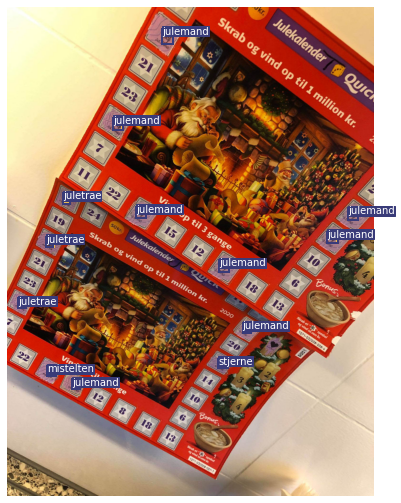

torch.Size([3, 982, 1102])
{'juletrae': 0, 'julemand': 3, 'rensdyr': 3, 'tromme': 1, 'mistelten': 5, 'lys': 2, 'kugle': 0, 'stjerne': 0}
Der var desværre ikke gevinst


<Figure size 432x288 with 0 Axes>

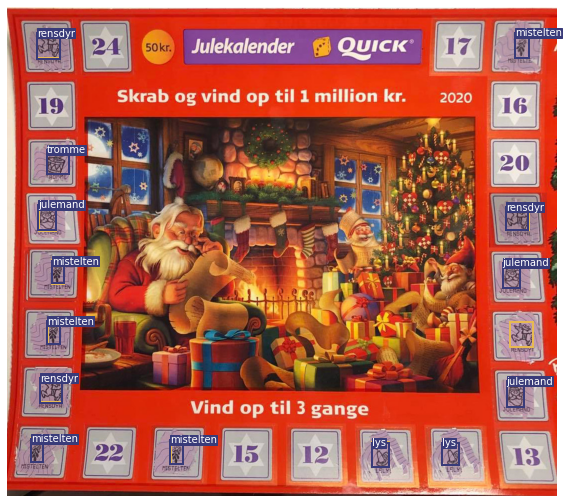

torch.Size([3, 1032, 884])
{'juletrae': 1, 'julemand': 3, 'rensdyr': 7, 'tromme': 2, 'mistelten': 2, 'lys': 4, 'kugle': 3, 'stjerne': 2}
Der var desværre ikke gevinst


<Figure size 432x288 with 0 Axes>

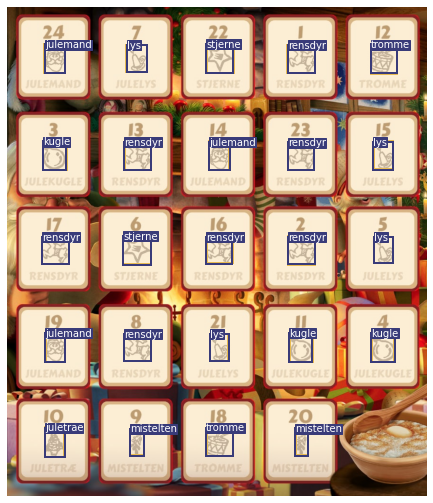

torch.Size([3, 1082, 1130])
{'juletrae': 9, 'julemand': 0, 'rensdyr': 1, 'tromme': 3, 'mistelten': 5, 'lys': 2, 'kugle': 3, 'stjerne': 1}
Der var desværre ikke gevinst


<Figure size 432x288 with 0 Axes>

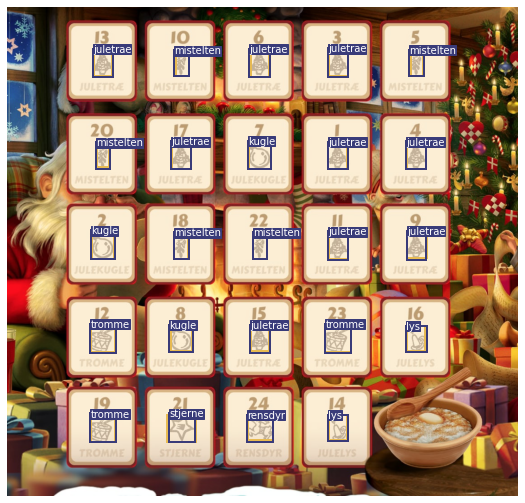

torch.Size([3, 1345, 1510])
{'juletrae': 0, 'julemand': 6, 'rensdyr': 0, 'tromme': 1, 'mistelten': 0, 'lys': 0, 'kugle': 0, 'stjerne': 0}
Der var desværre ikke gevinst


<Figure size 432x288 with 0 Axes>

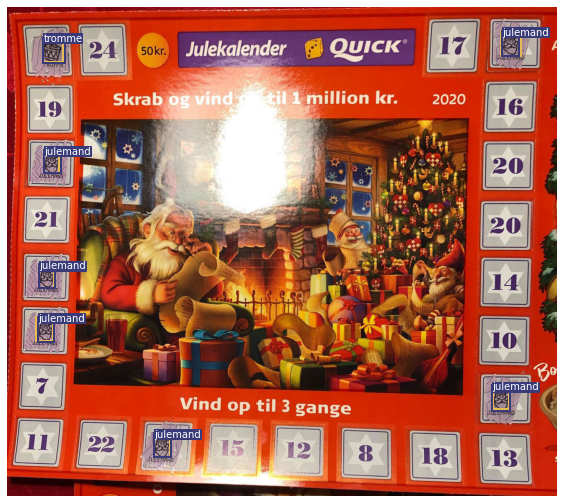

torch.Size([3, 1413, 1536])
{'juletrae': 0, 'julemand': 3, 'rensdyr': 0, 'tromme': 3, 'mistelten': 3, 'lys': 0, 'kugle': 0, 'stjerne': 0}
Der var desværre ikke gevinst


<Figure size 432x288 with 0 Axes>

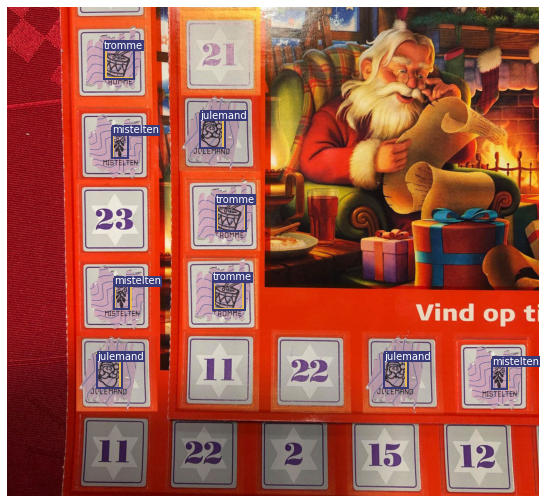

torch.Size([3, 1536, 2048])
{'juletrae': 4, 'julemand': 2, 'rensdyr': 7, 'tromme': 1, 'mistelten': 2, 'lys': 3, 'kugle': 3, 'stjerne': 1}
Der var desværre ikke gevinst


<Figure size 432x288 with 0 Axes>

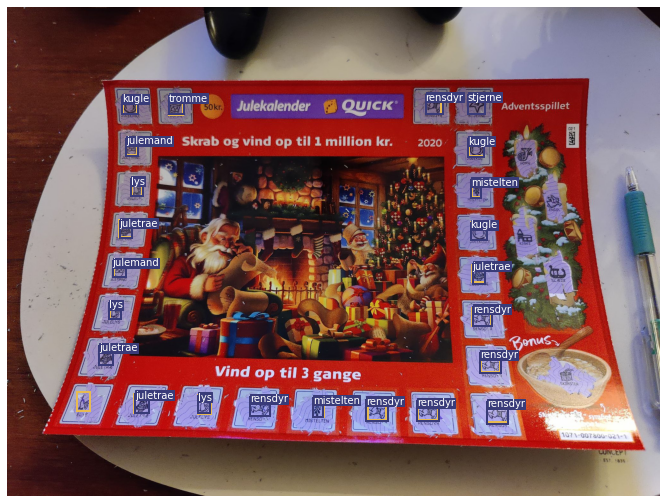

torch.Size([3, 1536, 2048])
{'juletrae': 1, 'julemand': 2, 'rensdyr': 7, 'tromme': 6, 'mistelten': 3, 'lys': 0, 'kugle': 3, 'stjerne': 1}
Der var desværre ikke gevinst


<Figure size 432x288 with 0 Axes>

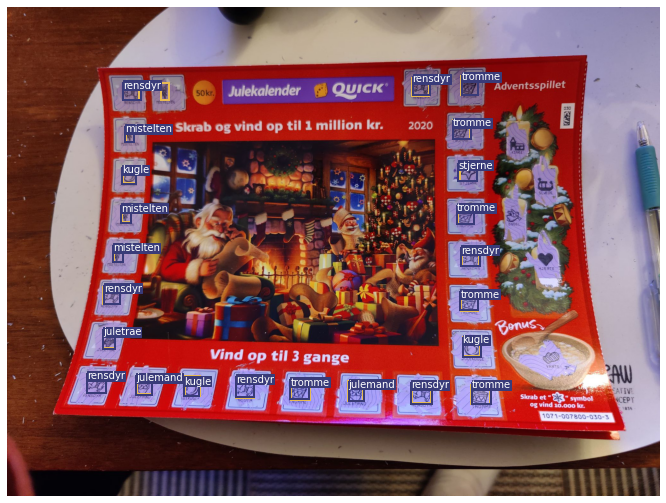

creating index...
index created!
Test:  [ 0/10]  eta: 0:00:08  model_time: 0.2129 (0.2129)  evaluator_time: 0.0127 (0.0127)  time: 0.8203  data: 0.5617  max mem: 1625
Test:  [ 9/10]  eta: 0:00:00  model_time: 0.1043 (0.1166)  evaluator_time: 0.0055 (0.0063)  time: 0.1938  data: 0.0616  max mem: 1625
Test: Total time: 0:00:02 (0.2038 s / it)
Averaged stats: model_time: 0.1043 (0.1166)  evaluator_time: 0.0055 (0.0063)
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.419
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.500
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.490
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.418
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.667
 Average Recall     (AR) @[ IoU

In [ ]:
for i in range(len(datasetValidation)):
  img, ground_true = datasetValidation[i]

  print(img.shape)
  model.eval()
  with torch.no_grad():
    pred = model([img.to(device)])

  display_pred(img,pred,ground_true,threshold=0.9)

evaluate(model, data_loader_test, device=device)


{'juletrae': 9, 'julemand': 1, 'rensdyr': 1, 'tromme': 2, 'mistelten': 5, 'lys': 2, 'kugle': 1, 'stjerne': 3}
GEVINST! Der er : 3 Julestjerner der udløser 50,-


<Figure size 432x288 with 0 Axes>

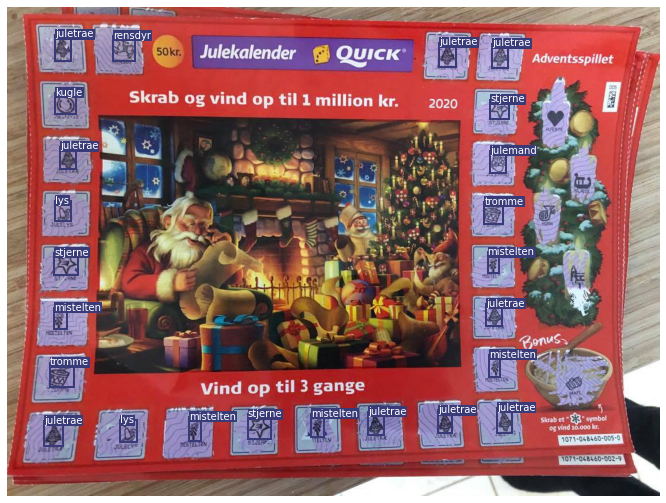

In [ ]:
from torchvision.transforms import ToTensor

# Download benchmarch images 


imgPath = 'testimg.jpg'
custom_img = Image.open(imgPath).convert("RGB")
custom_img = T.ToTensor()(custom_img,None)
custom_img = custom_img[0]

model.eval()
with torch.no_grad():
  pred = model([custom_img.to(device)])

display_pred(custom_img,pred,threshold=0.9)

In [ ]:
torch.save(model,'best.mdl')